In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import pareto 
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random
import censusdata

# Investigating the Racial Composition of Census Block Groups in 2020

### Import data:

    1. census block group shape file
    2. race & ethnicity count per block group from U.S. Census Bureau & ACS 5 year estimates

In [2]:
#import boston block groups
blockgroup20_BOS = gpd.read_file('../Data/Census2020_BlockGroups/Census2020_BlockGroups.shp')

#exclude islands
blockgroup20_BOS = blockgroup20_BOS[blockgroup20_BOS['GEOID20'] != '250259801011']
blockgroup20_BOS = blockgroup20_BOS.to_crs('epsg:4326')
blockgroup20_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_STAr,Shape_STLe,geometry
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,413598.0,+42.3833695,-071.0707743,1.807118e+07,29256.866068,"POLYGON ((-71.08097 42.38232, -71.08095 42.382..."
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,0.0,+42.3882285,-071.0046816,2.374654e+06,9142.174252,"POLYGON ((-71.01084 42.38613, -71.00891 42.386..."
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,270.0,+42.3913407,-071.0020343,2.446949e+06,11579.546171,"POLYGON ((-71.00629 42.39098, -71.00628 42.391..."
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,158777.0,+42.3886205,-070.9934424,8.026752e+06,16626.718823,"POLYGON ((-71.00113 42.38710, -71.00100 42.387..."
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,0.0,+42.3459611,-071.1020344,1.570220e+06,5510.560013,"POLYGON ((-71.10507 42.34670, -71.10457 42.346..."


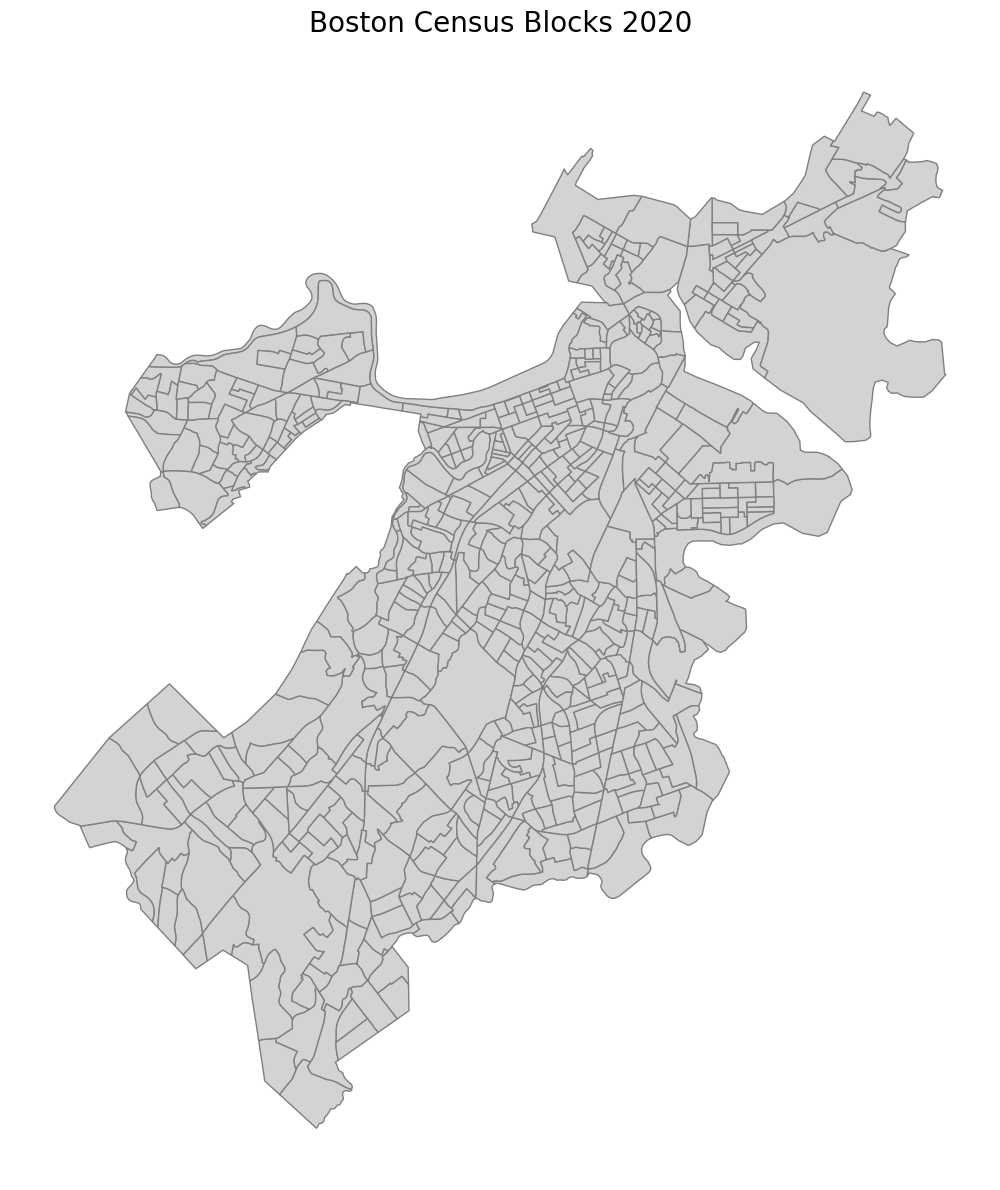

In [3]:
#visualize map
fig, ax = plt.subplots(figsize=(12,12))
blockgroup20_BOS.plot(ax=ax, color = 'lightgrey', edgecolor = 'grey')
ax.set_title('Boston Census Blocks 2020', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()

In [4]:
#import relevent race data from B03002 ACS table

#Step 1: iterate through to create a list of desired ACS column values & associated values
hispanic_race_columns = []

for i in range(1,13):
    if i == 2 or i == 10 or i == 11:
        pass
    elif i <10:
        hispanic_race_columns.append('B03002_00{}E'.format(i))
    else:
        hispanic_race_columns.append('B03002_0{}E'.format(i))


column_vals = ['Total','White', 'Black or African American','American Indian and Alaska Native', 'Asain',\
               'Native Hawaiian and Other Pacific Islander', 'Some other race alone', 'Two or More Races']

hisp_col_vals = ['Total'] + [item+', not hispanic' for item in column_vals[1:]] +['Hispanic or Latino']
col_dict = {hispanic_race_columns[i]: hisp_col_vals[i] for i in range(len(hisp_col_vals))}
print(col_dict)

#Step 2: Get Massachusetts, Suffolk County census codes

boscounties = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2020)
print(boscounties['Suffolk County, Massachusetts'])


{'B03002_001E': 'Total', 'B03002_003E': 'White, not hispanic', 'B03002_004E': 'Black or African American, not hispanic', 'B03002_005E': 'American Indian and Alaska Native, not hispanic', 'B03002_006E': 'Asain, not hispanic', 'B03002_007E': 'Native Hawaiian and Other Pacific Islander, not hispanic', 'B03002_008E': 'Some other race alone, not hispanic', 'B03002_009E': 'Two or More Races, not hispanic', 'B03002_012E': 'Hispanic or Latino'}
Summary level: 050, state:25> county:025


Now we are going to use the censusdata package to retrieve data associated with the above column names for values with stateid = 25 and countyid = 025, e.g. Massachusetts, Suffolk County. This is the county that the city of Boston is in.

In [5]:
#define function to retrieve census/ACS data given the variables defined above
def get_acs5_data(yr,stateid,countyid,column_ls,col_dict):
    """
    Parameters
    ----------
    yr: int
        The census year of interest
    stateid: str
        State id  of interest in the form of a string
    countyid: str
        County id of interest in the form of a string
    column_ls: list
        The list of ACS column values you are looking to extract
    col_dict: dict
        Dictionary assigning categorical values to associated ACS column
        
        key: ACS column (e.g. B3002_001E)
        value: Categorical value (e.g. 'Total')
        
    Returns
    -------
    df: dataframe
        Dataframe containing population counts of interest at the available
        geographical/spatial resolution (e.g. census blocks, tracts, block groups)
    """
    
    df = censusdata.download('acs5', yr,
               censusdata.censusgeo([('state', stateid),
                                     ('county', countyid),
                                     ('block group', '*')]),
                                      column_ls)
    df.reset_index(inplace=True)
    df['index'] = df['index'].astype('str')
    
    Block_Group = []
    tract = []
    for index, row in df.iterrows():
        Block_Group.append(row['index'][:13])
        tract.append(row['index'][-21:-15])

    df['Block Group'] = Block_Group
    df['Tract'] = tract
    
    df = df.rename(columns = col_dict)
    df = df.rename(columns = {'index':'Geographical Information'})
    
    return df

In [6]:
bos_ethnicity = get_acs5_data(2020,'25','025',hispanic_race_columns,col_dict)
bos_ethnicity.head()

,Geographical Information,Total,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,"Block Group 3, Census Tract 1304.02, Suffolk C...",732,491,0,0,46,0,0,12,183,Block Group 3,130402
1,"Block Group 2, Census Tract 1304.04, Suffolk C...",940,752,24,0,99,0,0,9,56,Block Group 2,130404
2,"Block Group 3, Census Tract 1304.06, Suffolk C...",390,214,95,0,0,0,0,0,81,Block Group 3,130406
3,"Block Group 1, Census Tract 1403, Suffolk Coun...",1172,54,422,0,0,0,0,0,696,Block Group 1,140300
4,"Block Group 4, Census Tract 1403, Suffolk Coun...",1006,204,766,0,0,0,0,0,36,Block Group 4,140300


In [7]:
#because Suffolk County contains geographies outside of the City of Boston,
#we will join the bos_ethnicity df to the boston block group df

acs5_blockg_BOS = blockgroup20_BOS.merge(bos_ethnicity, how = 'left', left_on = ['TRACTCE20','NAMELSAD20'], right_on = ['Tract','Block Group'])
acs5_blockg_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,1086,165,0,102,0,0,25,101,Block Group 1,040600
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,...,956,162,0,82,0,0,0,1191,Block Group 1,051101
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,...,326,26,0,18,0,0,0,649,Block Group 4,051101
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,...,0,0,0,0,0,0,0,0,Block Group 1,981600
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,...,465,34,0,201,0,0,15,56,Block Group 3,010204


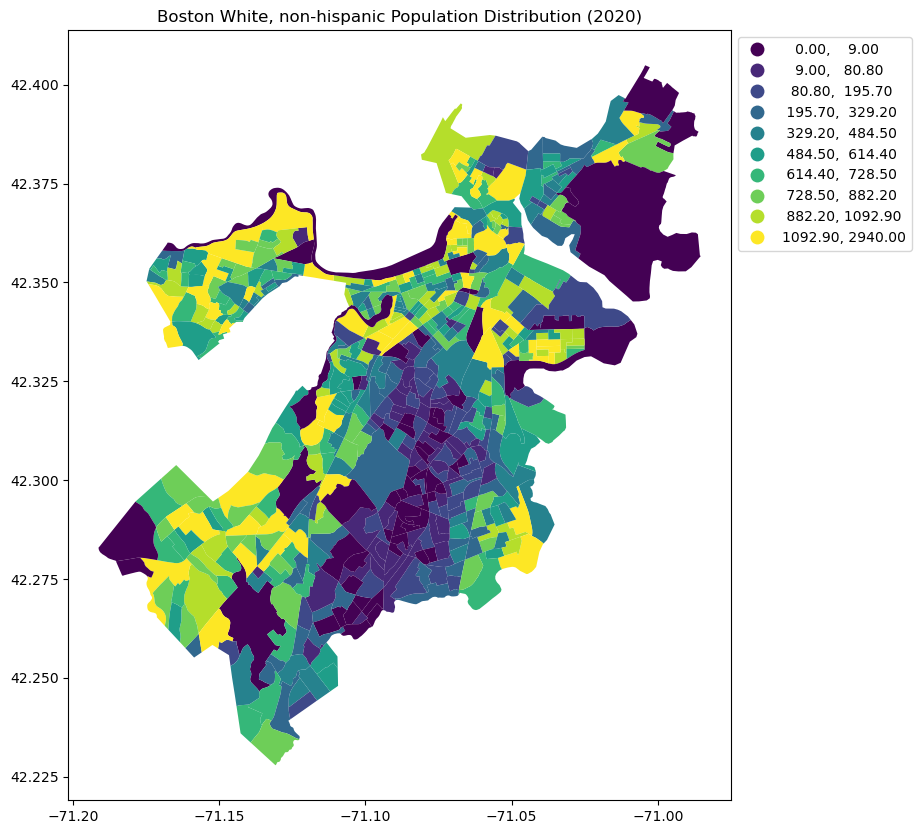

In [8]:
#visualize the distribution of white population
fig,ax = plt.subplots(figsize = (10,10))
acs5_blockg_BOS.plot(column = 'White, not hispanic', ax = ax, k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
plt.title('Boston White, non-hispanic Population Distribution (2020)')
plt.show()

In the above chloropleth, we can see the "southern core" of the city, which mainly consists of Dorchester and Roxbury neighborhoods, contains little to no white population. 

In [9]:
#calculate percent totals for each block group and race in the df
for clm in hisp_col_vals[1:]:
    acs5_blockg_BOS[clm+' Percent Total'] = acs5_blockg_BOS[clm]/acs5_blockg_BOS['Total']
acs5_blockg_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,Block Group,Tract,"White, not hispanic Percent Total","Black or African American, not hispanic Percent Total","American Indian and Alaska Native, not hispanic Percent Total","Asain, not hispanic Percent Total","Native Hawaiian and Other Pacific Islander, not hispanic Percent Total","Some other race alone, not hispanic Percent Total","Two or More Races, not hispanic Percent Total",Hispanic or Latino Percent Total
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,Block Group 1,040600,0.734280,0.111562,0.0,0.068966,0.0,0.0,0.016903,0.068289
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,...,Block Group 1,051101,0.399833,0.067754,0.0,0.034295,0.0,0.0,0.000000,0.498118
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,...,Block Group 4,051101,0.319921,0.025515,0.0,0.017664,0.0,0.0,0.000000,0.636899
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,...,Block Group 1,981600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,...,Block Group 3,010204,0.603113,0.044099,0.0,0.260700,0.0,0.0,0.019455,0.072633


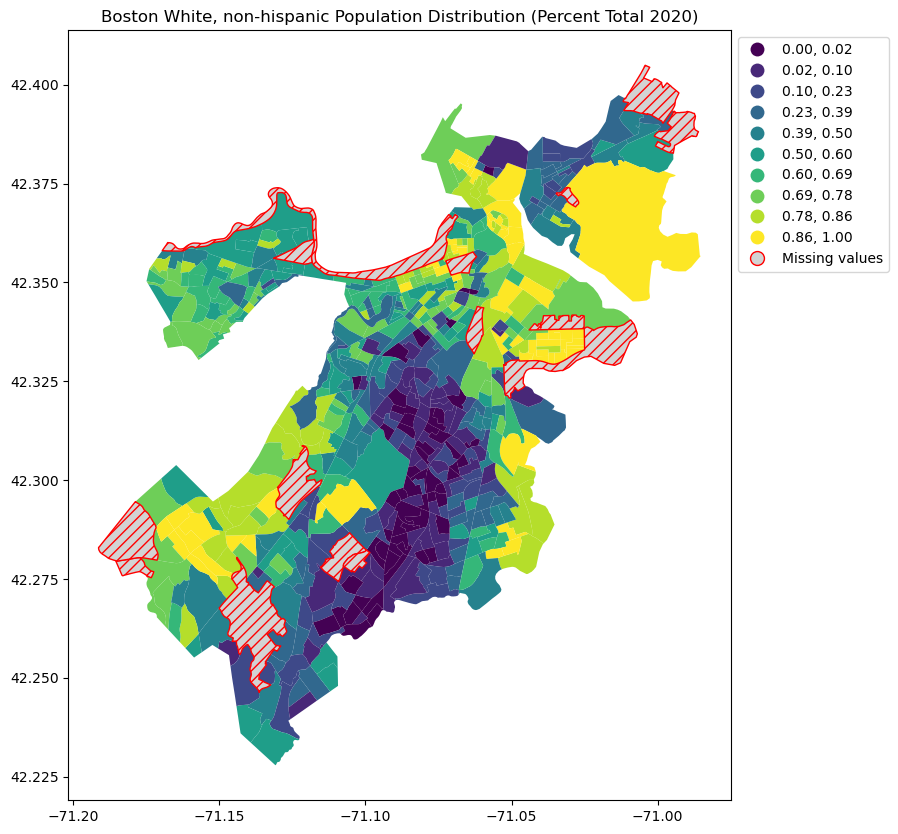

In [10]:
fig,ax = plt.subplots(figsize = (10,10))

acs5_blockg_BOS.plot(column='White, not hispanic Percent Total',ax = ax,
                     k=10, scheme='Quantiles', legend=True, 
                     missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "red",
                                        "hatch": "///",
                                        "label": "Missing values",}
                     ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
plt.title('Boston White, non-hispanic Population Distribution (Percent Total 2020)')
plt.show()

## Investigate Neighborhood Population Trends

In [11]:
#import neighborhood shape file

nbhood_BOS = gpd.read_file('../Data/Boston_Neighborhoods/Boston_Neighborhoods.shp')
nbhood_BOS

,OBJECTID,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((757409.123 2924367.749, 757457..."
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((762983.826 2944104.016, 763014.250 2..."
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((766903.580 2947645.876, 766280.013 2..."
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((764826.911 2947985.998, 764607.180 2..."
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((773315.750 2952419.751, 773111.500 2..."
5,32,Leather District,15.639908,27,0.02,6.812717e+05,3237.140537,"POLYGON ((775544.125 2952813.250, 775437.006 2..."
6,33,Chinatown,76.324410,26,0.12,3.324678e+06,9736.590413,"POLYGON ((775667.139 2953742.283, 775653.203 2..."
7,34,North End,126.910439,14,0.20,5.527506e+06,16177.826815,"POLYGON ((777233.200 2959748.000, 777315.301 2..."
8,35,Roxbury,2108.469072,16,3.29,9.184455e+07,49488.800485,"POLYGON ((765347.826 2932136.987, 765304.140 2..."
9,36,South End,471.535356,32,0.74,2.054000e+07,17912.333569,"POLYGON ((772855.065 2952041.273, 772854.812 2..."


In [12]:
acs5_blockg_BOS.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
#Exclude Harbor Islands Neighborhood
nbhood_BOS = nbhood_BOS[nbhood_BOS['Name']!= 'Harbor Islands']
#convert crs to match acs5_blockg_BOS df
nbhood_BOS = nbhood_BOS.to_crs(4326)

In [14]:
#spatial join census block groups to neighborhoods
full_df = acs5_blockg_BOS.sjoin(nbhood_BOS, how = 'left')
full_df.head(10)

,OBJECTID_left,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,"Two or More Races, not hispanic Percent Total",Hispanic or Latino Percent Total,index_right,OBJECTID_right,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,0.016903,0.068289,12,39,Charlestown,871.541223,4,1.36,3.796418e+07,57509.688645
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,...,0.000000,0.498118,11,38,East Boston,3012.059593,8,4.71,1.313845e+08,121089.100852
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,...,0.000000,0.636899,11,38,East Boston,3012.059593,8,4.71,1.313845e+08,121089.100852
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,...,NaN,NaN,11,38,East Boston,3012.059593,8,4.71,1.313845e+08,121089.100852
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,...,0.019455,0.072633,16,43,Fenway,560.618461,34,0.88,2.442044e+07,24620.876452
5,6,25,025,010204,2,250250102042,Block Group 2,G5030,S,67705.0,...,0.016749,0.083747,3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148
5,6,25,025,010204,2,250250102042,Block Group 2,G5030,S,67705.0,...,0.016749,0.083747,16,43,Fenway,560.618461,34,0.88,2.442044e+07,24620.876452
6,7,25,025,110607,3,250251106073,Block Group 3,G5030,S,363586.0,...,0.023537,0.027990,0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597
6,7,25,025,110607,3,250251106073,Block Group 3,G5030,S,363586.0,...,0.023537,0.027990,1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161
7,8,25,025,981000,1,250259810001,Block Group 1,G5030,S,1134184.0,...,NaN,NaN,0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597


Some census block groups are within multiple neighborhoods. We will calculate the intersecting area of the two polygons to estimate population more accurately

In [15]:
full_df.columns

Index(['OBJECTID_left', 'STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLKGRPCE20',
       'GEOID20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       'INTPTLAT20', 'INTPTLON20', 'Shape_STAr', 'Shape_STLe', 'geometry',
       'Geographical Information', 'Total', 'White, not hispanic',
       'Black or African American, not hispanic',
       'American Indian and Alaska Native, not hispanic',
       'Asain, not hispanic',
       'Native Hawaiian and Other Pacific Islander, not hispanic',
       'Some other race alone, not hispanic',
       'Two or More Races, not hispanic', 'Hispanic or Latino', 'Block Group',
       'Tract', 'White, not hispanic Percent Total',
       'Black or African American, not hispanic Percent Total',
       'American Indian and Alaska Native, not hispanic Percent Total',
       'Asain, not hispanic Percent Total',
       'Native Hawaiian and Other Pacific Islander, not hispanic Percent Total',
       'Some other race alone, not hispanic Percent Tota

In [16]:
full_df = full_df.merge(nbhood_BOS[['Neighborho', 'geometry']], on = 'Neighborho', suffixes=('_bg', '_nbh'))
full_df.head()

,OBJECTID_left,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,Hispanic or Latino Percent Total,index_right,OBJECTID_right,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry_nbh
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,0.068289,12,39,Charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39050, -71.07415 ..."
1,19,25,025,040401,2,250250404012,Block Group 2,G5030,S,312222.0,...,0.000000,12,39,Charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39050, -71.07415 ..."
2,40,25,025,040801,3,250250408013,Block Group 3,G5030,S,410674.0,...,0.015435,12,39,Charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39050, -71.07415 ..."
3,68,25,025,040801,2,250250408012,Block Group 2,G5030,S,480124.0,...,0.101765,12,39,Charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39050, -71.07415 ..."
4,219,25,025,040401,1,250250404011,Block Group 1,G5030,S,121181.0,...,0.083922,12,39,Charlestown,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39050, -71.07415 ..."


In [17]:
geometry_intersecting = []
intersecting_area = []
total_area = []
for i in range(0,len(full_df)):
    geometry_intersecting.append(full_df['geometry_bg'][i].intersection(full_df['geometry_nbh'][i]))
    intersecting_area.append(full_df['geometry_bg'][i].intersection(full_df['geometry_nbh'][i]).area)
    total_area.append(full_df['geometry_bg'][i].area)

In [18]:
full_df['geometry_intersecting'] = geometry_intersecting
full_df['intersecting_area'] = intersecting_area
full_df['Total_BG_area'] = total_area
full_df['area_ratio'] = full_df['intersecting_area'] / full_df['Total_BG_area']

#calcalate race population estimates based on area_ratio calculation
est_clm_ls = []
for clm in hisp_col_vals:
    est_clm_ls.append(clm+' Estimate')
    full_df[clm+' Estimate'] = full_df[clm]*full_df['area_ratio']

In [19]:
full_df.head()

,OBJECTID_left,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,area_ratio,Total Estimate,"White, not hispanic Estimate","Black or African American, not hispanic Estimate","American Indian and Alaska Native, not hispanic Estimate","Asain, not hispanic Estimate","Native Hawaiian and Other Pacific Islander, not hispanic Estimate","Some other race alone, not hispanic Estimate","Two or More Races, not hispanic Estimate",Hispanic or Latino Estimate
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,0.751930,1112.104695,816.596145,124.068475,0.0,76.696876,0.0,0.0,18.798254,75.944945
1,19,25,025,040401,2,250250404012,Block Group 2,G5030,S,312222.0,...,0.921084,745.156843,616.205103,27.632516,0.0,11.974090,0.0,0.0,89.345134,0.000000
2,40,25,025,040801,3,250250408013,Block Group 3,G5030,S,410674.0,...,0.520812,1282.239607,1204.117779,14.582741,0.0,39.581726,0.0,0.0,4.166498,19.790863
3,68,25,025,040801,2,250250408012,Block Group 2,G5030,S,480124.0,...,0.587551,565.811896,49.354309,14.101231,0.0,444.776330,0.0,0.0,0.000000,57.580027
4,219,25,025,040401,1,250250404011,Block Group 1,G5030,S,121181.0,...,1.000000,2407.000000,1807.000000,52.000000,0.0,346.000000,0.0,0.0,0.000000,202.000000


In [20]:
cols = ['Name'] + est_clm_ls
nbhood_race = full_df[cols].groupby(by = 'Name').sum()

In [21]:
nbhood_race.sort_values('Total Estimate', ascending = False)

,Total Estimate,"White, not hispanic Estimate","Black or African American, not hispanic Estimate","American Indian and Alaska Native, not hispanic Estimate","Asain, not hispanic Estimate","Native Hawaiian and Other Pacific Islander, not hispanic Estimate","Some other race alone, not hispanic Estimate","Two or More Races, not hispanic Estimate",Hispanic or Latino Estimate
Name,,,,,,,,,
Dorchester,126033.925007,28122.766203,54705.851581,276.148730,11530.143151,0.000000,1608.223655,5025.486197,24765.305490
Roxbury,52689.834708,7310.597854,25460.895434,430.236836,2355.075756,0.190413,656.062587,1585.719533,14891.056295
Brighton,48238.492569,30966.724829,2197.620634,28.624169,7664.772326,86.968271,548.854662,1360.456536,5384.471143
Jamaica Plain,44781.501613,24566.336751,6370.151539,30.856744,2552.436464,0.000000,224.603061,1602.981415,9434.135638
East Boston,43566.482188,14729.652130,1042.583616,13.172661,1761.961454,77.000000,273.129956,672.706977,24996.275393
South Boston,37705.299601,28260.420301,2005.668755,0.999207,2313.441633,0.000000,114.881889,856.607714,4153.280101
Hyde Park,36739.671453,8443.057690,16362.434475,19.449143,775.267706,0.000000,126.734736,787.924205,10224.803499
West Roxbury,33987.948484,22769.921721,3788.428811,19.000135,2410.234471,0.000000,36.993473,1287.957431,3675.412442
Fenway,33490.441826,19028.366421,1636.042793,97.627091,6928.745287,92.885672,181.923118,1390.704689,4134.146754


In [22]:
#convert estimated values into percent totals and drop Total Estimate column
for col in nbhood_race.columns.to_list()[1:]:
    nbhood_race[col] = round(nbhood_race[col] / nbhood_race['Total Estimate'] * 100, 2)   
nbhood_race = nbhood_race.drop(columns = ['Total Estimate'])

In [23]:
#We will visualize the data using a heatmap
nbhood_race.sort_values(by = 'White, not hispanic Estimate', ascending = False).style.background_gradient(cmap='Oranges', axis='columns', vmin=0, vmax = 100).set_precision(2)

,"White, not hispanic Estimate","Black or African American, not hispanic Estimate","American Indian and Alaska Native, not hispanic Estimate","Asain, not hispanic Estimate","Native Hawaiian and Other Pacific Islander, not hispanic Estimate","Some other race alone, not hispanic Estimate","Two or More Races, not hispanic Estimate",Hispanic or Latino Estimate
Name,,,,,,,,
North End,85.66,2.56,0.12,3.49,0.00,0.26,0.61,7.30
Beacon Hill,84.70,0.81,0.01,5.62,0.00,0.15,1.35,7.36
South Boston Waterfront,83.13,2.36,0.00,9.06,0.00,0.00,2.66,2.78
Bay Village,77.49,0.02,0.00,12.35,0.00,0.00,7.05,3.09
South Boston,74.95,5.32,0.00,6.14,0.00,0.30,2.27,11.02
Charlestown,72.09,7.11,0.00,8.72,0.00,0.00,2.63,9.46
Back Bay,70.72,4.15,0.16,12.08,0.01,0.00,2.95,9.94
West Roxbury,66.99,11.15,0.06,7.09,0.00,0.11,3.79,10.81
Leather District,65.99,0.03,0.00,23.48,0.00,0.00,3.33,7.17


Out of the 25 neighborhoods in Boston, 80% have a singular race group making up the majority of it's population. Of the neighborhoods with majority race groups, 85% have a majority white population (68% of all Boston neighborhoods).

In a [2020 report](https://cecr.ed.psu.edu/sites/default/files/Demography_Report_FINAL_7.24.20.pdf) published by Beyond Test Scores Project and Center for Education and Civil Rights, researchers define segregation in Massachusetts schools using the 70-25 model outlines below.

        "According to the 70-25 model, a school is racially diverse when no single racial group accounts
        for more than 70 percent of the total population and at least 25 percent of students in the
        school are white."
    
Using this model, the researchers were able to categorize Massachusetts schools into:

          - Intensely Segregated non-white (e.g. more than 70% of population is non-white)
          - Intensely Segregated white (e.g. more than 70% of population is white)
          - 70-25 diverse (e.g. population satisfies the 70-25 model).
          
I will use the same framework & the metrics provided in the table above to categorize Boston's neighborhoods.

In [35]:
#First lets sum up non-white race columns 
non_white_cols = nbhood_race.columns.to_list()[1:]
print(non_white_cols)
nbhood_race_cats = nbhood_race.copy()
nbhood_race_cats['Non-white'] = nbhood_race[non_white_cols].sum(axis = 1)
nbhood_race_cats = nbhood_race_cats.drop(columns = non_white_cols)
nbhood_race_cats = nbhood_race_cats.rename(columns = {'White, not hispanic Estimate': 'White'})

['Black or African American, not hispanic Estimate', 'American Indian and Alaska Native, not hispanic Estimate', 'Asain, not hispanic Estimate', 'Native Hawaiian and Other Pacific Islander, not hispanic Estimate', 'Some other race alone, not hispanic Estimate', 'Two or More Races, not hispanic Estimate', 'Hispanic or Latino Estimate']


In [36]:
nbhood_race_cats.sort_values(by = 'White', ascending = False)

,White,Non-white
Name,,
North End,85.66,14.34
Beacon Hill,84.70,15.30
South Boston Waterfront,83.13,16.86
Bay Village,77.49,22.51
South Boston,74.95,25.05
Charlestown,72.09,27.92
Back Bay,70.72,29.29
West Roxbury,66.99,33.01
Leather District,65.99,34.01


In [37]:
#Intensely Segregrated White --> white > 70 & non-white < 25
#Intensely Segregrated Non-White --> white < 25 & non-white > 70
#70-25 diverse --> 25 < white =< 70 & non-white =< 70

#create new column in df
nbhood_race_cats['Category'] = ""
#iterate over rows
for i in range(0,len(nbhood_race_cats)):
    if nbhood_race_cats['White'][i] > 70:
        nbhood_race_cats['Category'][i] = 'Intensely Segregrated White'
    if nbhood_race_cats['Non-white'][i] > 70:
        nbhood_race_cats['Category'][i] = 'Intensely Segregrated Non-White'
    if (nbhood_race_cats['White'][i] > 25) & (nbhood_race_cats['White'][i] <= 70) & (nbhood_race_cats['Non-white'][i] <= 70):
        nbhood_race_cats['Category'][i] = '70-25 Diverse'

In [38]:
nbhood_race_cats

,White,Non-white,Category
Name,,,
Allston,54.95,45.04,70-25 Diverse
Back Bay,70.72,29.29,Intensely Segregrated White
Bay Village,77.49,22.51,Intensely Segregrated White
Beacon Hill,84.70,15.30,Intensely Segregrated White
Brighton,64.20,35.81,70-25 Diverse
Charlestown,72.09,27.92,Intensely Segregrated White
Chinatown,19.62,80.38,Intensely Segregrated Non-White
Dorchester,22.31,77.70,Intensely Segregrated Non-White
Downtown,63.63,36.37,70-25 Diverse


In [39]:
nbhood_race_cats['Category'].value_counts()

70-25 Diverse                      13
Intensely Segregrated White         7
Intensely Segregrated Non-White     5
Name: Category, dtype: int64

It looks like nealry 50% of neighborhoods satisfy the 70-25 model while the other 50% are intensely segregated, white or non-white. Lets take a look at these trends on a chloropleth.

In [40]:
nbhood_race_cats = nbhood_race_cats.merge(nbhood_BOS, on = 'Name', how = 'left')
nbhood_race_cats

,Name,White,Non-white,Category,OBJECTID,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry
0,Allston,54.95,45.04,70-25 Diverse,51,998.534479,24,1.56,4.349599e+07,37859.091242,"POLYGON ((-71.13517 42.34601, -71.13823 42.347..."
1,Back Bay,70.72,29.29,Intensely Segregrated White,37,399.314411,2,0.62,1.739407e+07,19455.671146,"POLYGON ((-71.07569 42.35691, -71.07579 42.356..."
2,Bay Village,77.49,22.51,Intensely Segregrated White,31,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34877, -71.06739 42.348..."
3,Beacon Hill,84.70,15.30,Intensely Segregrated White,41,200.156904,30,0.31,8.718800e+06,14303.829017,"POLYGON ((-71.07141 42.36118, -71.07080 42.361..."
4,Brighton,64.20,35.81,70-25 Diverse,44,1840.408596,25,2.88,8.016788e+07,48787.519652,"POLYGON ((-71.13517 42.34601, -71.13528 42.345..."
5,Charlestown,72.09,27.92,Intensely Segregrated White,39,871.541223,4,1.36,3.796418e+07,57509.688645,"MULTIPOLYGON (((-71.07416 42.39050, -71.07415 ..."
6,Chinatown,19.62,80.38,Intensely Segregrated Non-White,33,76.324410,26,0.12,3.324678e+06,9736.590413,"POLYGON ((-71.05791 42.35237, -71.05796 42.352..."
7,Dorchester,22.31,77.70,Intensely Segregrated Non-White,48,4662.879457,6,7.29,2.031142e+08,104344.034005,"MULTIPOLYGON (((-71.05896 42.32875, -71.05812 ..."
8,Downtown,63.63,36.37,70-25 Diverse,42,397.472846,7,0.62,1.731385e+07,34612.804441,"POLYGON ((-71.05342 42.36129, -71.05276 42.360..."
9,East Boston,33.81,66.19,70-25 Diverse,38,3012.059593,8,4.71,1.313845e+08,121089.100852,"POLYGON ((-70.99546 42.39393, -70.99524 42.393..."


In [41]:
#convert to geodataframe
nbhood_race_cats = gpd.GeoDataFrame(nbhood_race_cats, geometry = nbhood_race_cats['geometry'], crs = 4326)

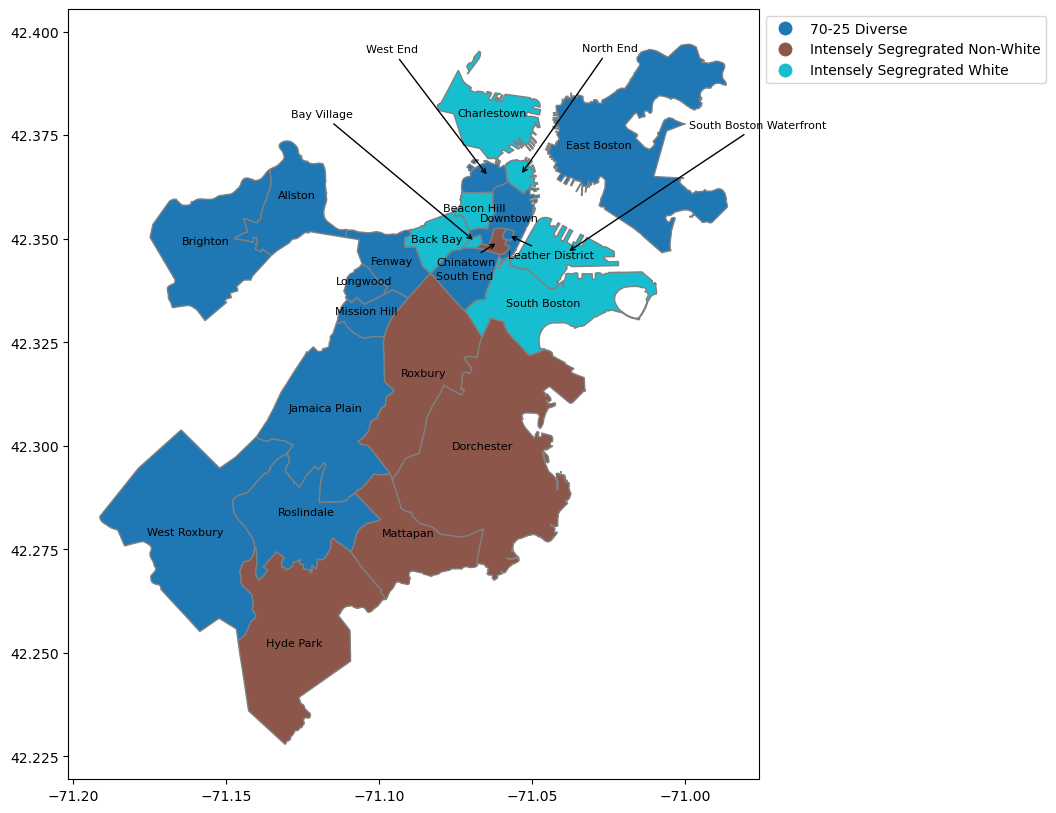

In [84]:
nbhood_race_cats['coords'] = nbhood_race_cats['geometry'].apply(lambda x: x.representative_point().coords[:])
nbhood_race_cats['coords'] = [coords[0] for coords in nbhood_race_cats['coords']]

#labels are sorted descending in the x axis
nbhood_race_cats["sort_key"] = [coord[0]  for coord in nbhood_race_cats["coords"]]
nbhood_race_cats.sort_values("sort_key" , inplace=True)
del nbhood_race_cats["sort_key"]

fig, ax = plt.subplots(figsize = (10,10))
nbhood_race_cats.plot(ax = ax, column = 'Category', legend = True, figsize = (10,10),edgecolor = 'grey',
                      legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

for idx, row in nbhood_race_cats[~nbhood_race_cats['Name'].isin(['North End', 'West End', 'Leather District','Chinatown','Bay Village', 'South Boston Waterfront'])].iterrows():
    plt.annotate(s = row['Name'], xy = row['coords'], horizontalalignment='center', color='black', fontsize = 8)
    
i = -0.06
j = 0
for idx, row in nbhood_race_cats[nbhood_race_cats['Name'].isin(['North End', 'West End','South Boston Waterfront', 'Leather District','Chinatown','Bay Village'])].iterrows():
    if j == 2 or j == 3:
        xtext = row['coords'][0] + i
        ytext = row['coords'][1] - 0.0055
    else:
        xtext = row['coords'][0] + i
        ytext = row['coords'][1] + 0.03
    plt.annotate(s = row['Name'], xy = row['coords'], xytext=(xtext,ytext), color='black', fontsize = 8 , arrowprops=dict(arrowstyle='->', connectionstyle="arc3"))
    i = i+0.02
    j = j + 1